In [1]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /opt/conda/envs/fastai/lib/python3.6/site-packages (1.5.6)


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/
# ! {sys.executable} -m pip install kaggle --upgrade

In [3]:
from fastai.vision import *

In [4]:
path = Config.data_path()/'notebooks'/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/storage/notebooks/planet')

In [7]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space

  0%|                                               | 0.00/2.94M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 2.94M/2.94M [00:00<00:00, 40.9MB/s]


In [15]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path} 

In [ ]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip 

In [22]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

In [13]:
# ! unzip -q -n {path}/planet-understanding-the-amazon-from-space.zip -d {path}

In [6]:
df = pd.read_csv(path/'train_v2.csv', engine='python')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [9]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

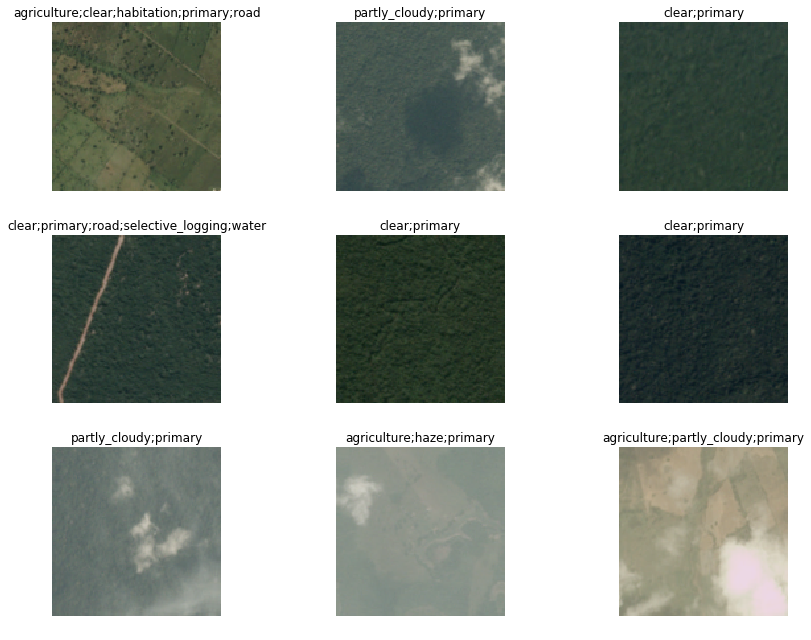

In [10]:
data.show_batch(rows=3, figsize=(12,9))

In [11]:
arch = models.resnet50

In [12]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


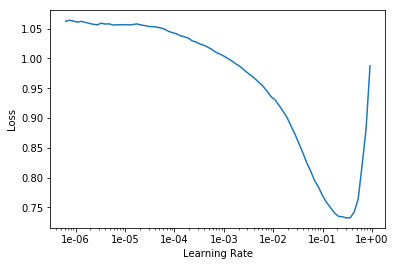

In [14]:
learn.recorder.plot()

In [15]:
lr = 0.01

In [16]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.135638,0.119463,0.946423,0.896325,01:10
1,0.111251,0.101962,0.948719,0.911749,01:09
2,0.103967,0.092950,0.956829,0.919842,01:09
3,0.096676,0.088853,0.956792,0.921935,01:09
4,0.089295,0.086652,0.955710,0.925302,01:09


In [17]:
learn.save('stage-1-rn50')

In [18]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


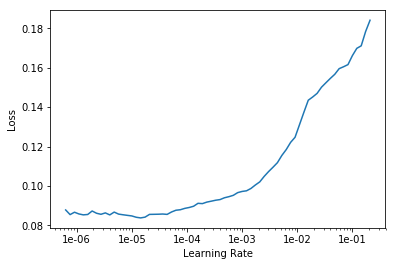

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093256,0.088081,0.955950,0.922883,01:31
1,0.092148,0.086227,0.953348,0.924271,01:31
2,0.086860,0.086271,0.957279,0.925924,01:31
3,0.085055,0.084638,0.958936,0.927791,01:31
4,0.081123,0.084347,0.958340,0.927950,01:32


In [21]:
learn.save('stage-2-rn50')

In [22]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [23]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


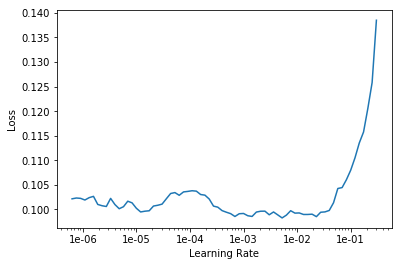

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr=1e-2/5

In [26]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.090955,0.087052,0.955398,0.925465,04:05
1,0.085411,0.084377,0.958398,0.927795,04:07
2,0.084889,0.083474,0.958529,0.927701,04:05
3,0.082049,0.082828,0.957774,0.928840,04:05
4,0.082427,0.082938,0.958515,0.928831,04:06


In [27]:
learn.save('stage-1-256-rn50')

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086827,0.087330,0.957577,0.923131,05:15
1,0.088784,0.084530,0.958231,0.927380,05:17
2,0.084073,0.082873,0.955645,0.928726,05:17
3,0.078514,0.081807,0.958965,0.929160,05:17
4,0.074427,0.081563,0.960055,0.931033,05:17


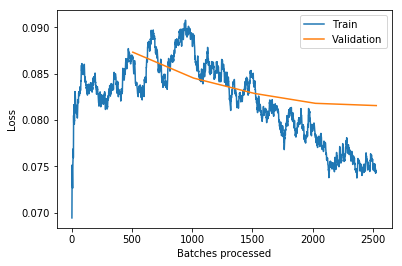

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.save('stage-2-256-rn50')

In [32]:
learn.export()